# Tutoriel : Appliquer une transformation à une image

**Guillaume Bourmaud - guillaume.bourmaud@enseirb-matmeca.fr**

## Utilisation IDE Spyder sur un ordinateur de l'Enseirb
1. Lancer une session linux (et non pas windows)
2. Aller dans "Applications", puis "Autre", puis "conda_pytorch" (un terminal devrait s'ouvrir)
3. Dans ce terminal, taper la commande suivante pour lancer Spyder :  
`spyder &`  
4. Configurer Spyder en suivant ces instructions [Lien configuration Spyder](https://gbourmaud.github.io/files/configuration_spyder_annotated.pdf).
***

Le principe de l'application d'une transformation à une image est expliqué dans le document suivant : [Lien transformation_image.pdf](https://gbourmaud.github.io/files/vision/TP/Tutoriel_transformation_image/transformation_image.pdf).  
Ce tutoriel est une implémentation python de ce principe. Nous considérons ici le cas où la transformation est une rotation autour du centre de l'image. Pour information, le fichier `.py` contenant le code complet de ce tutoriel et l'image à transformer sont disponibles ici : [Lien main_example_rotation.py](https://gbourmaud.github.io/files/vision/TP/Tutoriel_transformation_image/main_example_rotation.py), [Lien Tour_eiffel.jpg](https://gbourmaud.github.io/files/vision/TP/Tutoriel_transformation_image/Tour_eiffel.jpg). 

Commençons par charger les bibliothèques dont nous avons besoin

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math

Nous aurons également besoin d'une fonction d'interpolation 2D

In [3]:
def interp2_bilinear(im, x, y):
    
    x0 = np.floor(x).astype(int)
    x1 = x0 + 1
    y0 = np.floor(y).astype(int)
    y1 = y0 + 1

    maskx = np.logical_or(x0<0, x1>im.shape[1]-1)
    masky = np.logical_or(y0<0, y1>im.shape[0]-1)
    mask_notvalid = np.logical_or(maskx,masky)
    
    x0[mask_notvalid] = 0
    x1[mask_notvalid] = 0
    y0[mask_notvalid] = 0
    y1[mask_notvalid] = 0
    
    if(len(im.shape)==3):
        Ia = im[ y0, x0, : ]
        Ib = im[ y1, x0, : ]
        Ic = im[ y0, x1, : ]
        Id = im[ y1, x1, : ]
        
        wa = np.expand_dims((x1-x) * (y1-y),axis=Ia.ndim-1)
        wb = np.expand_dims((x1-x) * (y-y0),axis=Ia.ndim-1)
        wc = np.expand_dims((x-x0) * (y1-y),axis=Ia.ndim-1)
        wd = np.expand_dims((x-x0) * (y-y0),axis=Ia.ndim-1)
    
    else:
        Ia = im[ y0, x0]
        Ib = im[ y1, x0]
        Ic = im[ y0, x1]
        Id = im[ y1, x1]
        
        wa = ((x1-x) * (y1-y))
        wb = ((x1-x) * (y-y0))
        wc = ((x-x0) * (y1-y))
        wd = ((x-x0) * (y-y0))


    return wa*Ia + wb*Ib + wc*Ic + wd*Id, mask_notvalid

Chargement et affichage de l'image que nous souhaitons transformer

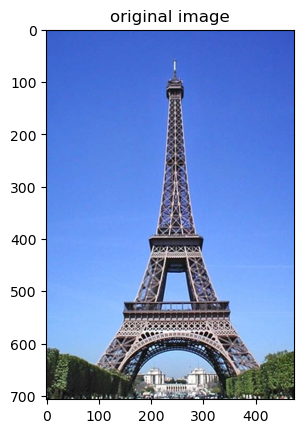

In [4]:
I = np.array(Image.open('Tour_eiffel.jpg')).astype(float)/255.
h,w,_ = I.shape
fig1, axs1 = plt.subplots(ncols=1)
axs1.imshow(I)
axs1.set_title('original image')
plt.pause(0.1)

Définition des paramètres de la rotation

In [5]:
theta = 60 #the resulting image should be rotated 60° right
center_rot = np.array([w/2., h/2.])

Définition de la taille de l'image transformée

In [6]:
h_new = 1280
w_new = 960

Définition de la fonction permettant de calculer les grilles d'interpolation

In [7]:
def getInterpolationGrids(theta, center_rot, h_new, w_new):
    
    theta_rad = theta*math.pi/180.
    rot_mat = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],[np.sin(theta_rad), np.cos(theta_rad)]])
    
    x = np.arange(0,w_new)
    y = np.arange(0,h_new)
    X, Y = np.meshgrid(x,y) #h_new x w_new
    
    p = np.zeros((h_new,w_new,2)) #h_new x w_new x 2
    p[:,:,0] = X
    p[:,:,1] = Y
    
    
    p_rot = ((p - np.array([w_new/2., h_new/2.])) @ rot_mat) + center_rot #h_new x w_new x 2

    XI = p_rot[:,:,0] #h_new x w_new
    YI = p_rot[:,:,1] #h_new x w_new
 

    return XI, YI

Calcul et affichage des grilles d'interpolation

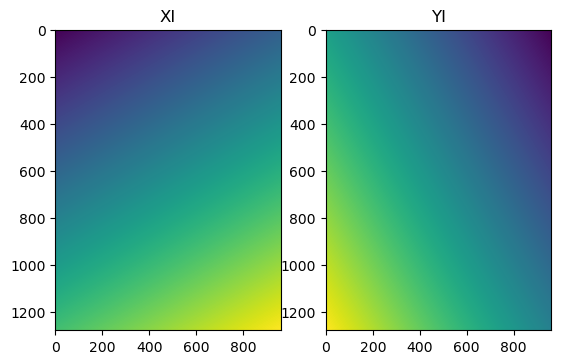

In [8]:
XI,YI = getInterpolationGrids(theta, center_rot, h_new, w_new)

fig2, axs2 = plt.subplots(ncols=2)
axs2[0].imshow(XI)
axs2[0].set_title('XI')
axs2[1].imshow(YI)
axs2[1].set_title('YI')
plt.pause(0.1)

Application de la transformation (interpolation)

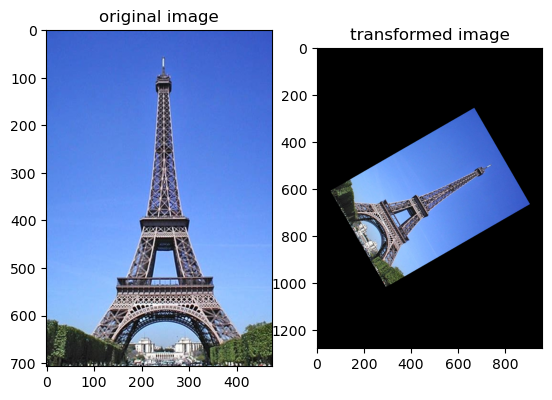

In [9]:
I_rot,_ = interp2_bilinear(I.astype(np.float32), XI.astype(np.float32), YI.astype(np.float32))

h,w,_ = I.shape
fig3, axs3 = plt.subplots(ncols=2)
axs3[0].imshow(I)
axs3[0].set_title('original image')
axs3[1].imshow(I_rot)
axs3[1].set_title('transformed image')
plt.pause(1.)

Sauvegarde de l'image transformée

In [10]:
Image.fromarray((I_rot*255).astype(np.uint8)).save("im_rot.bmp")